# This notebook aims to provide a basic insight into the dataset
Specifically, to explore the general facts about the sample population and to find possible curiosities

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import colors as mcolors
import seaborn
seaborn.set()

# Age extraction

In [2]:
users = pd.read_csv('Data/userlist_filt.csv')
ages = users.groupby(['age','gender']).size().reset_index(name='count')
repeated_indices = ages.index.repeat(ages['count'])
ages_expanded = ages.loc[repeated_indices, ['age', 'gender']].reset_index(drop=True)
ages['age'] = ages['age'].astype('int64')
ages = ages.groupby('age').sum().reset_index()

Plotting age distribution

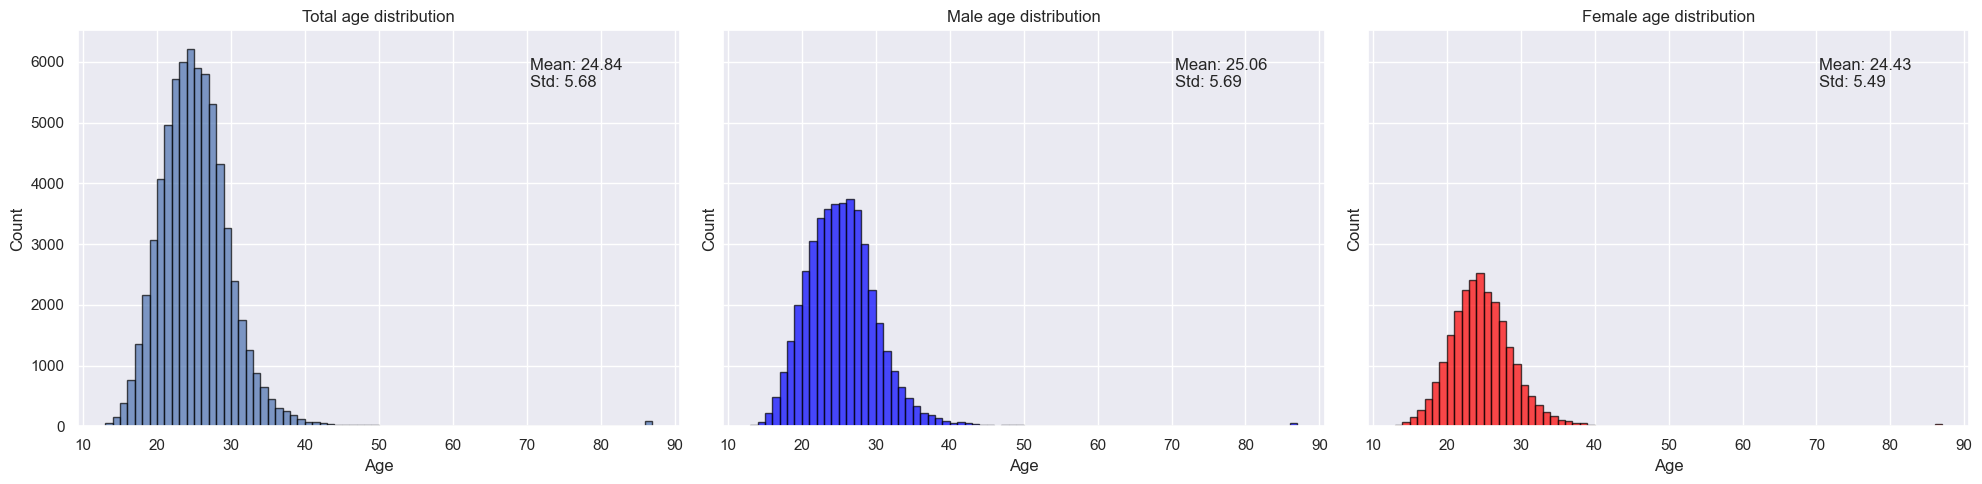

In [3]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,sharex='col', sharey='row', figsize=(20, 5))
ax1.hist(ages_expanded['age'], bins=range(min(ages['age']), max(ages['age'])), edgecolor='black', alpha=0.7)
ax1.annotate(f'Mean: {ages_expanded["age"].mean():.2f}\nStd: {ages_expanded["age"].std():.2f}', xy=(max(ages['age'])*0.8,max(ages['count'])*0.9))
ax1.set_title('Total age distribution')
ax1.set_xlabel('Age')
ax1.set_ylabel('Count')

male = ages_expanded[ages_expanded['gender']=="Male"]
ax2.hist(male['age'], bins=range(min(ages['age']), max(ages['age'])), edgecolor='black', alpha=0.7, color='blue')
ax2.annotate(f'Mean: {male["age"].mean():.2f}\nStd: {male["age"].std():.2f}', xy=(max(ages['age'])*0.8,max(ages['count'])*0.9))
ax2.set_title('Male age distribution')
ax2.set_xlabel('Age')
ax2.set_ylabel('Count')

female = ages_expanded[ages_expanded['gender']=="Female"]
ax3.hist(female["age"], bins=range(min(ages['age']), max(ages['age'])), edgecolor='black', alpha=0.7,color='red')
ax3.annotate(f'Mean: {female["age"].mean():.2f}\nStd: {female["age"].std():.2f}', xy=(max(ages['age'])*0.8,max(ages['count'])*0.9))
ax3.set_title('Female age distribution')
ax3.set_xlabel('Age')
ax3.set_ylabel('Count')
plt.tight_layout()
plt.show()

The results above allow us to see that the reported ages of people in the anime community seem to be normally distributed with a mean around 25 years.

# Country loading

In [4]:
countries = users.groupby('country').size().reset_index(name='count')
countries.rename(columns={'country': 'NAME', 'count': 'User_Count'}, inplace=True)
world = gpd.read_file('Data/ne_110m_admin_0_sovereignty/ne_110m_admin_0_sovereignty.shp')
world = world[(world['TYPE'] == 'Sovereign country') | (world['TYPE'] == 'Country') | (world['TYPE'] == 'Sovereignty')]
world = world.merge(countries, how='left', on='NAME')

Plotting user counts by country with choropleth graph

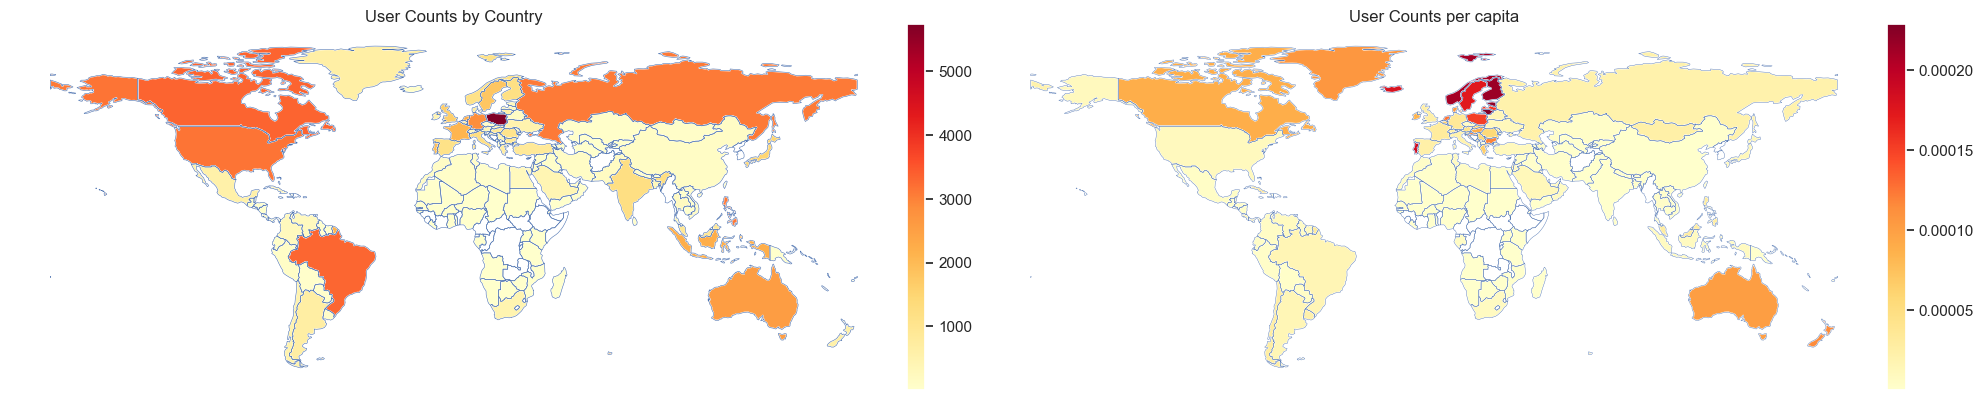

In [5]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 5))

world.boundary.plot(ax=ax1, linewidth=0.4)
choropleth = world.plot(column='User_Count', ax=ax1, legend=False, cmap='YlOrRd')

world_adjusted  = world.copy()
world_adjusted['User_Count'] = world_adjusted['User_Count'] / world_adjusted['POP_EST']
world_adjusted.boundary.plot(ax=ax2, linewidth=0.3)
choropleth_adjusted = world_adjusted.plot(column='User_Count', ax=ax2, legend=False, cmap='YlOrRd')

sm = plt.cm.ScalarMappable(cmap='YlOrRd',norm=mcolors.Normalize(vmin=world['User_Count'].min(), vmax=world['User_Count'].max()))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax1, orientation='vertical', fraction=0.02, pad=0.01)

sm2 = plt.cm.ScalarMappable(cmap='YlOrRd',norm=mcolors.Normalize(vmin=world_adjusted['User_Count'].min(), vmax=world_adjusted['User_Count'].max()))
sm2.set_array([])
cbar2 = fig.colorbar(sm2, ax=ax2, orientation='vertical', fraction=0.02, pad=0.01)
ax1.axis('off')
ax1.set_title('User Counts by Country')
ax2.axis('off')
ax2.set_title('User Counts per capita')
plt.tight_layout()
plt.show()

The choropleth graph shows an interesting picture. It appears that the largest demographic of this website is in Poland.

Even after adjusting for the population, Poland still appears to be among the highest.

# Rating and views


In [6]:
ratings = users['stats_mean_score']
watched_episodes = users[(users['stats_episodes'] < 20000)&(users['stats_episodes'] >0)].stats_episodes
watches_episodes_under2000 = users[(users['stats_episodes'] < 2000)&(users['stats_episodes'] >0)].stats_episodes

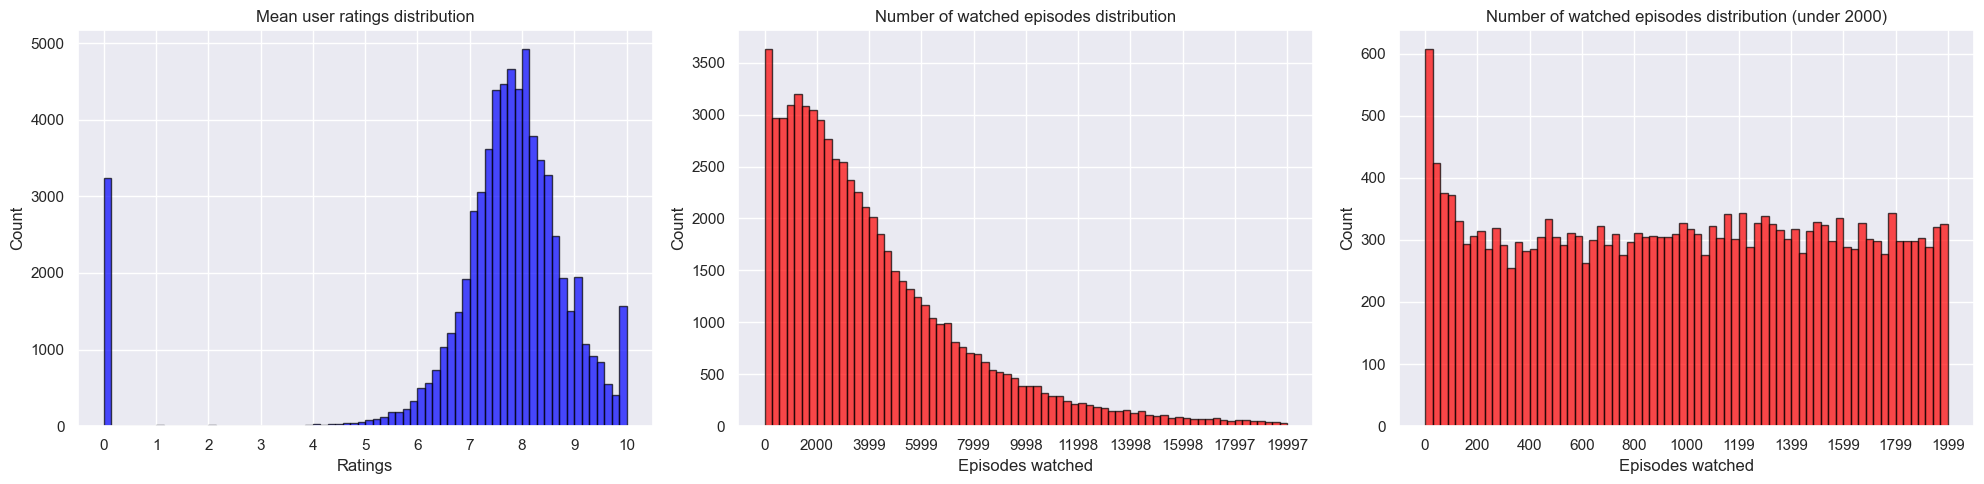

In [7]:
fig,(ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.hist(ratings.values, bins=70, edgecolor='black', alpha=0.7, color='blue')
ax1.set_title('Mean user ratings distribution')
ax1.set_xticks(np.linspace(0,10,11))
ax1.set_xlabel('Ratings')
ax1.set_ylabel('Count')

ax2.hist(watched_episodes.values, bins=70, edgecolor='black', alpha=0.7, color='red')
ax2.set_title('Number of watched episodes distribution')
ax2.set_xticks(np.linspace(0,np.max(watched_episodes.values),11))
ax2.set_xlabel('Episodes watched')
ax2.set_ylabel('Count')
ax3.hist(watches_episodes_under2000.values, bins=70, edgecolor='black', alpha=0.7, color='red')
ax3.set_title('Number of watched episodes distribution (under 2000)')
ax3.set_xticks(np.linspace(0,np.max(watches_episodes_under2000.values),11))
ax3.set_xlabel('Episodes watched')
ax3.set_ylabel('Count')
plt.tight_layout()
plt.show()

 The ratings distribution shows that people usually rate the shows they finish highly, with an exception for users rating 0.

The watched episodes distribution shows that the majority of users have watched under 2353 episodes, among the majority population on plot 3, we can  see that the values are uniformly distributed before their fall-off

Knowing that many accounts have around 0 episodes watched, and that there's a lot of accounts with mean rating 0, we want to suggest a test: are the accounts with no episodes watched related to accounts with 0 mean rating?


# Top genres based on rating

In [8]:
animes = pd.read_csv(('Data/animelist_filt.csv'))
genre_columns = [col for col in animes.columns if col.startswith('genre_')]
genre_popularity = animes[genre_columns].multiply(animes['scored_by'], axis=0).sum()
genre_popularity_df = genre_popularity.reset_index()
genre_popularity_df.columns = ['Genre', 'Total_Scored_By']
genre_popularity_df['Genre'] = genre_popularity_df['Genre'].str.replace('genre_','', regex=False)

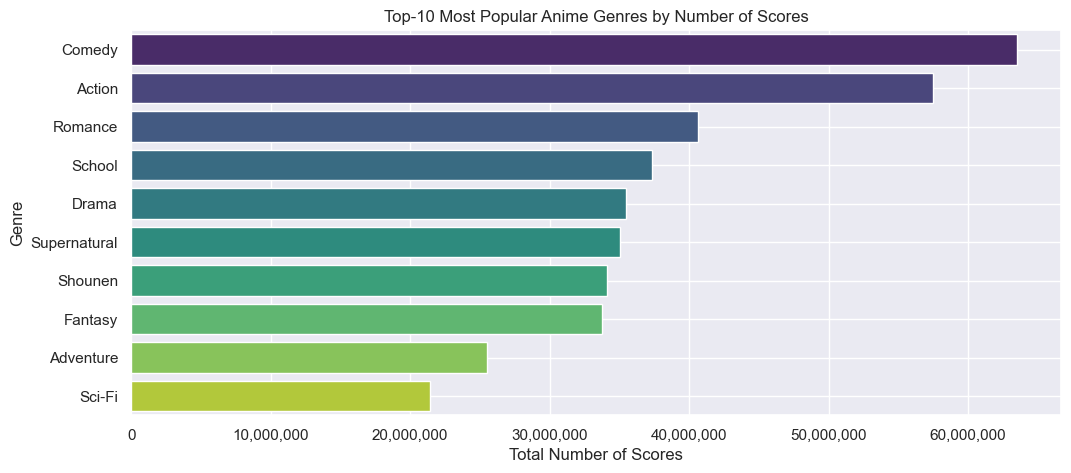

In [9]:
plt.figure(figsize=(12, 5))
seaborn.barplot(x='Total_Scored_By', y='Genre', data=genre_popularity_df.sort_values(by='Total_Scored_By', ascending=False).head(10), hue='Genre',palette='viridis', legend=False)
plt.title('Top-10 Most Popular Anime Genres by Number of Scores')
plt.xlabel('Total Number of Scores')
plt.ylabel('Genre')
formatter = ticker.FuncFormatter(lambda x, _: f'{int(x):,}')
plt.gca().xaxis.set_major_formatter(formatter)
plt.grid(True)
plt.show()

Looks like Comedy and Action shows lead with a big gap. (note: a show can have multiple genres)